In [1]:
import matplotlib.pyplot as plt
from solvers import anderson

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)

    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))

In [8]:
import torch.autograd as autograd

class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        print(f"z_star: {z}")
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [5]:
def anderson_tut(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.solve(y[:,:n+1], H[:,:n+1,:n+1])[0][:, 1:n+1, 0]   # (bsz x n)

        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res

In [9]:
f = ResNetLayer(64,128)
deq = DEQFixedPoint(f, anderson_tut, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32)
out = deq(X)
(out*torch.randn_like(out)).sum().backward()

z_star: tensor([[[[-4.8424e-01,  1.0523e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.8424e-01,  2.2766e+00],
          [-4.8424e-01, -4.8424e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.8424e-01, -4.8424e-01],
          [-4.8424e-01, -4.8424e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.2239e-01, -4.8424e-01],
          ...,
          [-4.8424e-01, -4.8424e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.8424e-01, -4.8424e-01],
          [-4.8424e-01, -4.8424e-01,  6.2648e-01,  ...,  1.8532e+00,
            3.8705e-01, -4.8424e-01],
          [ 4.7981e-01, -4.4680e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.8424e-01,  1.1110e+00]],

         [[-4.8424e-01, -4.8424e-01, -1.3425e-01,  ...,  4.1592e+00,
           -4.8424e-01, -2.0421e-01],
          [ 4.3107e+00, -4.8424e-01, -4.8424e-01,  ..., -4.8424e-01,
           -4.8424e-01,  1.0204e+00],
          [-4.8424e-01, -4.8424e-01,  1.0169e+00,  ..., -4.8424e-01,
           -4.8424e-01, -1.8527e-01],
          ..

Text(0, 0.5, 'Residual')

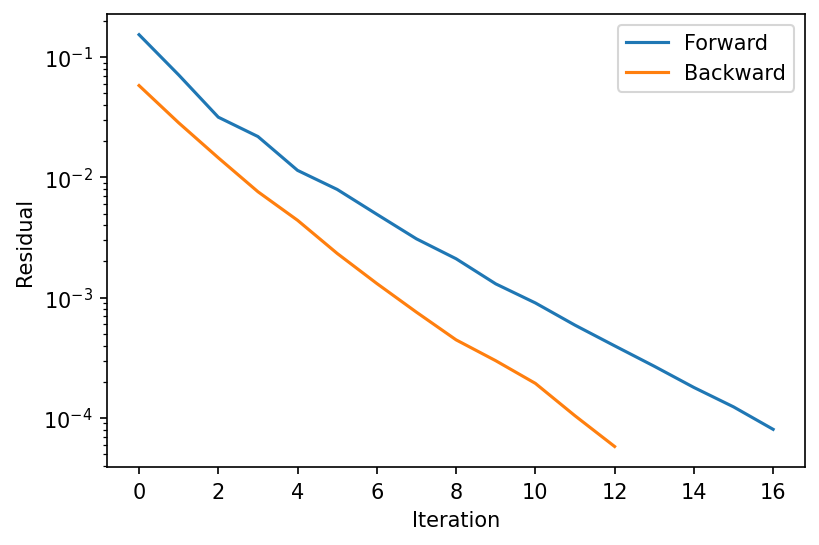

In [10]:
plt.figure(dpi=150)
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")